- LSTM forecast pipeline

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


/var/folders/7f/pn2lysgd6cx02fkc066bbrp40000gn/T/ipykernel_33776/1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


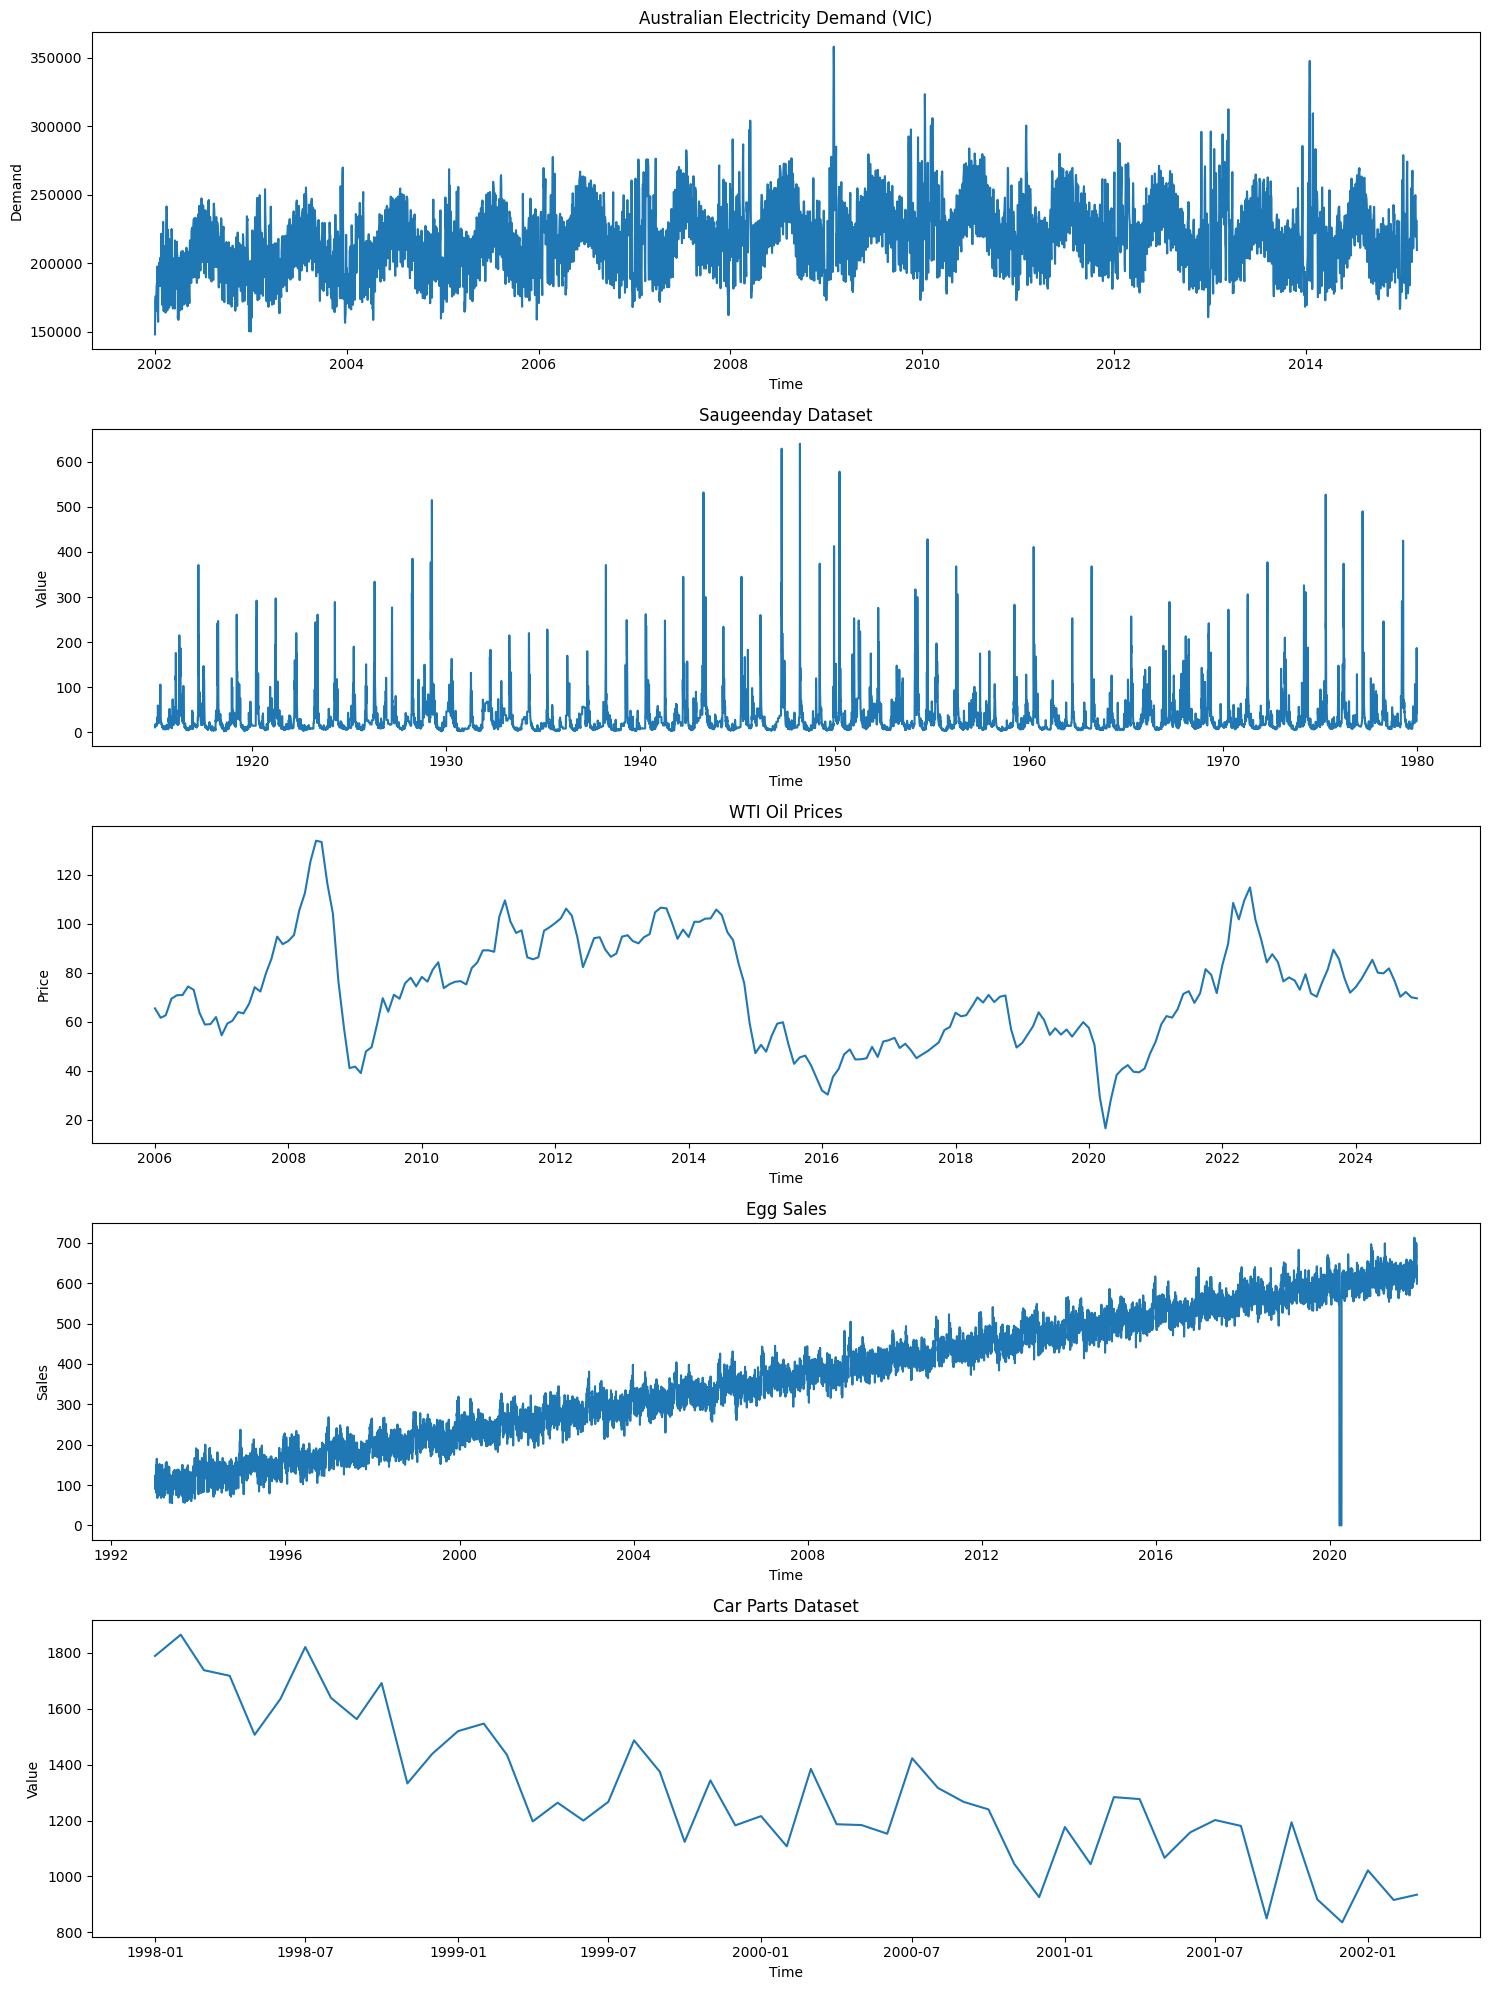

In [26]:
%run "datagetter.ipynb"
%run "basic_functions.ipynb"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def apporximate_lookback(train_df):
    """
    Approximate the lookback period for the LSTM model.
    """
    # should have done that by checkking in whic htimeframe the seasonailty occurs
    lookback = 0.1 * len(train_df)
    lookback = int(lookback)
    return lookback
    
def lstm_forecast(
    train_df, test_df,   # train_df and test_df are the training and test dataframes
    lookback=14,        # lookback is the number of previous time steps to use for prediction
    lstm_units=64,      # number of units in the LSTM layer
    dropout=0.2,        # dropout rate
    epochs=20,          # number of epochs
    batch_size=32,      # batch size
    show_plots=False,   # show plots    
    figsize=(14, 6),    # figure size
    alpha=0.05,         # alpha is the confidence interval
    val_frac=0.1        # Fraction of training data to use for validation
):
    """
    LSTM forecasting function with separate validation split from training set.
    Returns predictions (np.ndarray) for the test set.
    """
   # --------------------------------------------------------------
    # 1. Scaling  (fit on train only, transform both splits)
    # --------------------------------------------------------------
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df['y'].values.reshape(-1, 1))
    test_scaled  = scaler.transform(test_df['y'].values.reshape(-1, 1))

    #lookback = apporximate_lookback(train_df)
    # --------------------------------------------------------------
    # 2. Supervised sequences for TRAIN + internal VAL only
    # --------------------------------------------------------------
    X, y = [], []
    for i in range(lookback, len(train_scaled)):  # *only training part*
        X.append(train_scaled[i - lookback:i, 0])
        y.append(train_scaled[i, 0])
    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y)

    # Chronological split
    val_size = max(1, int(len(X) * val_frac))
    X_train, X_val = X[:-val_size], X[-val_size:]
    y_train, y_val = y[:-val_size], y[-val_size:]

    # --------------------------------------------------------------
    # 3. Build & train the model
    # --------------------------------------------------------------
    model = Sequential([
        LSTM(lstm_units, input_shape=(lookback, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=0
    )

    # --------------------------------------------------------------
    # 4. Rolling forecast over the test horizon (no test leakage)
    # --------------------------------------------------------------
    history = list(train_scaled.flatten())          # start with last TRAIN obs
    y_pred_scaled = []

    for _ in range(len(test_df)):
        X_input = np.array(history[-lookback:]).reshape(1, lookback, 1)
        next_scaled = model.predict(X_input, verbose=0)[0, 0]
        y_pred_scaled.append(next_scaled)
        history.append(next_scaled)                 # feed *prediction* back in

    # --------------------------------------------------------------
    # 5. Inverse-scale + book-keeping
    # --------------------------------------------------------------
    y_pred      = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()
    y_test_true = scaler.inverse_transform(test_scaled).flatten()
    test_dates  = test_df['ds'].iloc[:len(y_pred)]

    # Optional: keep the original variable names people look for
    y_pred_scaled = np.array(y_pred_scaled)
    # 5. Plot
    if show_plots:
        plt.figure(figsize=figsize)  # create a figure with the given size
        plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')  # plot the training data
        plt.plot(test_df['ds'].iloc[:len(y_test_true)], y_test_true, label='Test Data', color='green')  # plot the test data
        plt.plot(test_df['ds'].iloc[:len(y_pred)], y_pred, label='LSTM Forecast', color='darkorange')  # plot the LSTM forecast
        plt.axvline(test_df['ds'].iloc[0], color='tab:red', linestyle='--', label='Train/Test Split')  # plot the train/test split
        plt.title('LSTM Forecast')  # title of the plot
        plt.xlabel('Date')  # x-axis label
        plt.ylabel('Value')  # y-axis label
        plt.legend()  # legend
        plt.grid(True)  # grid
        plt.tight_layout()
        plt.show()

    # 6. Return only predictions for the test set, as expected by cross-val function
    return y_pred


/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


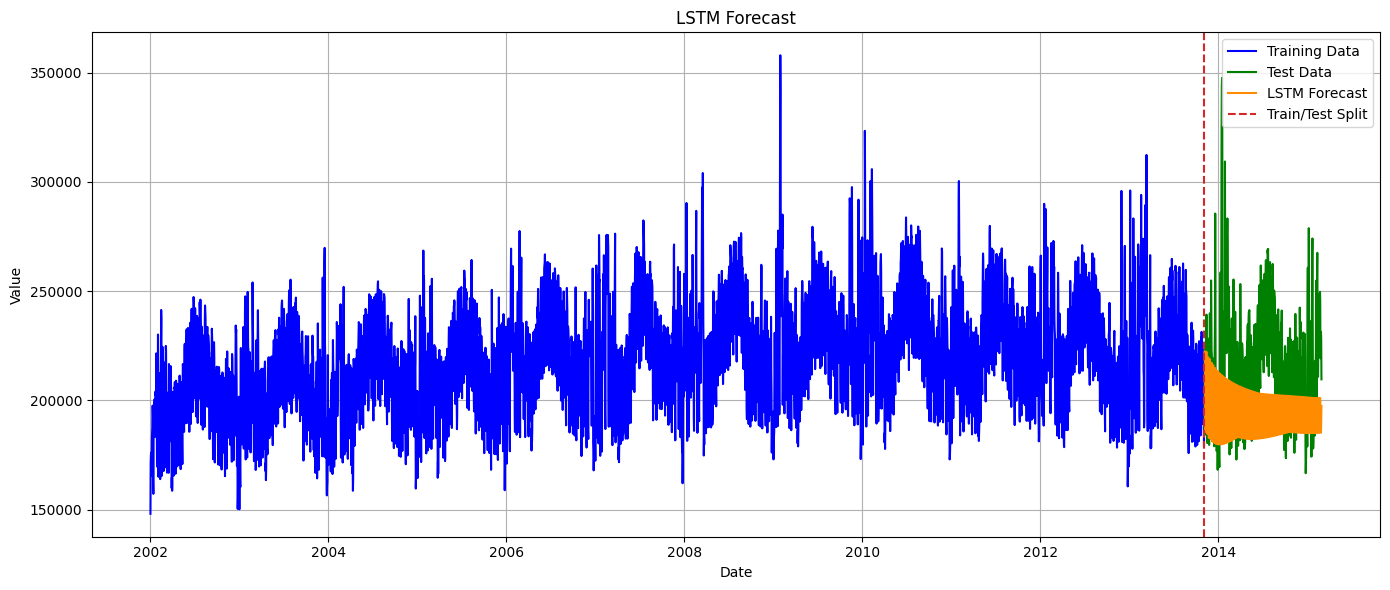

In [28]:
train_df, test_df = split_train_test(australian_electricity_demand_df, test_size=0.1)
lstm_forecasts = lstm_forecast(
    train_df, test_df,
    show_plots=True
)

/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


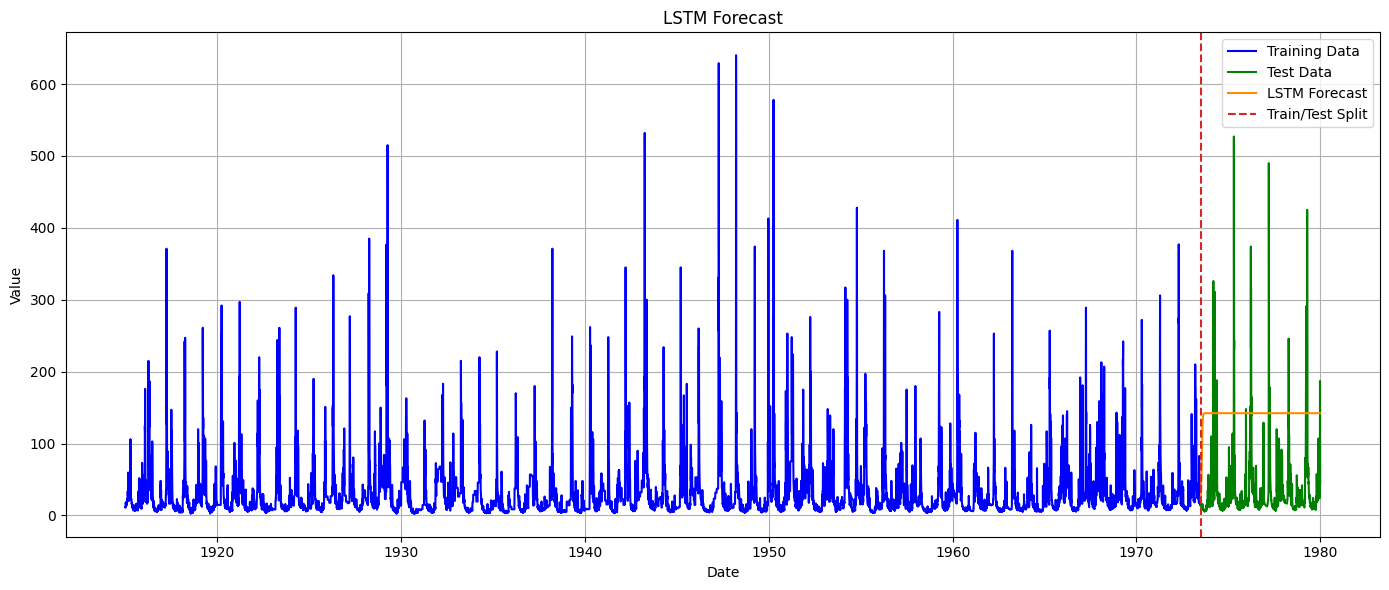

In [29]:
train_df, test_df = split_train_test(saugeen_river_df, test_size=0.1)
lstm_forecasts = lstm_forecast(
    train_df, test_df,
    show_plots=True
)

/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


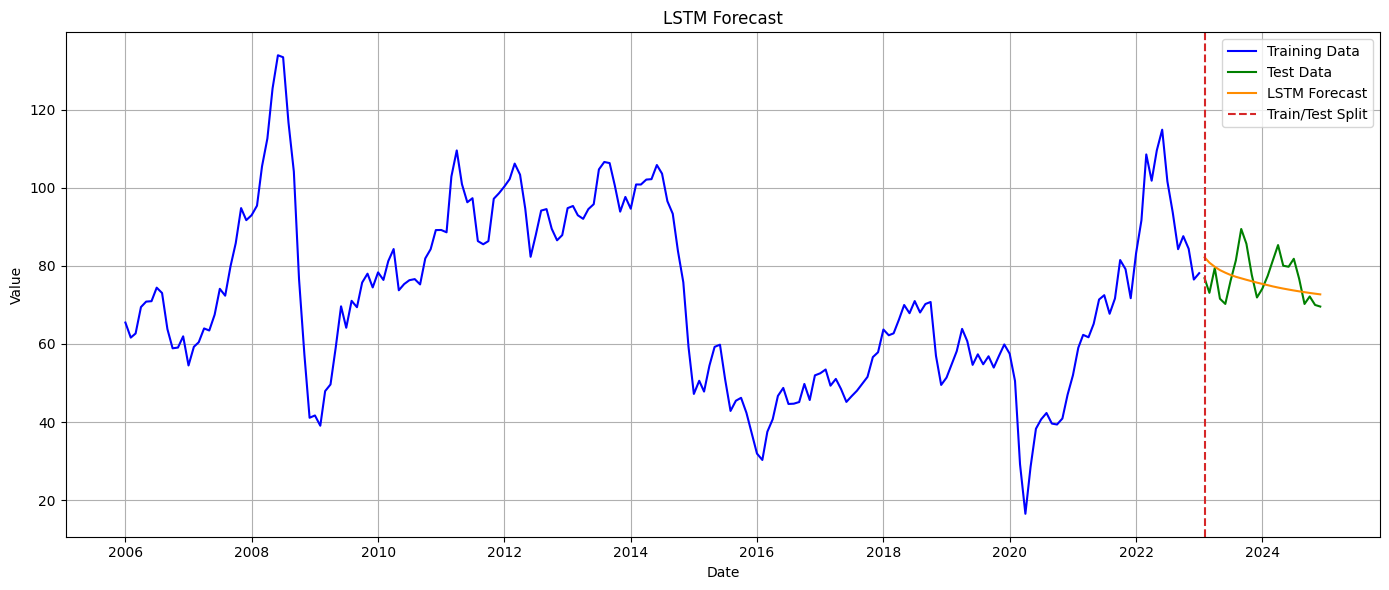

In [30]:
train_df, test_df = split_train_test(wti_oil_df, test_size=0.1) 
lstm_forecasts = lstm_forecast(
    train_df, test_df,
    show_plots=True
)


/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


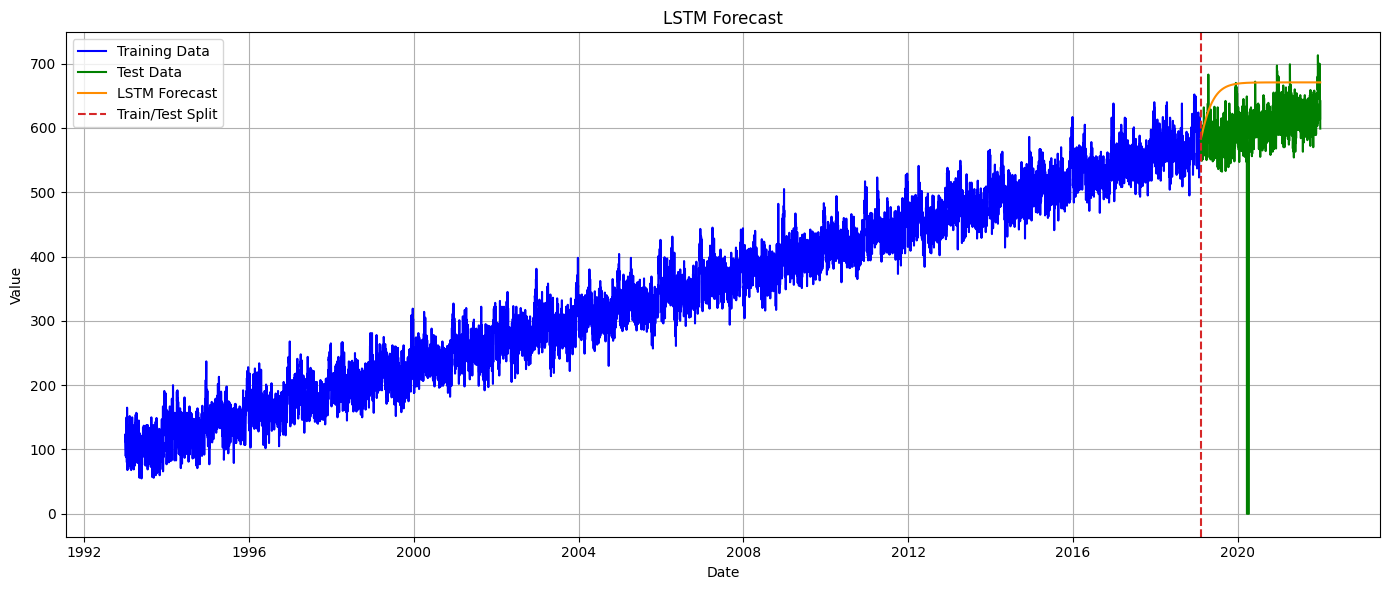

In [31]:
train_df, test_df = split_train_test(egg_sales_df, test_size=0.1)
lstm_forecasts = lstm_forecast(
    train_df, test_df,
    show_plots=True
)

/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


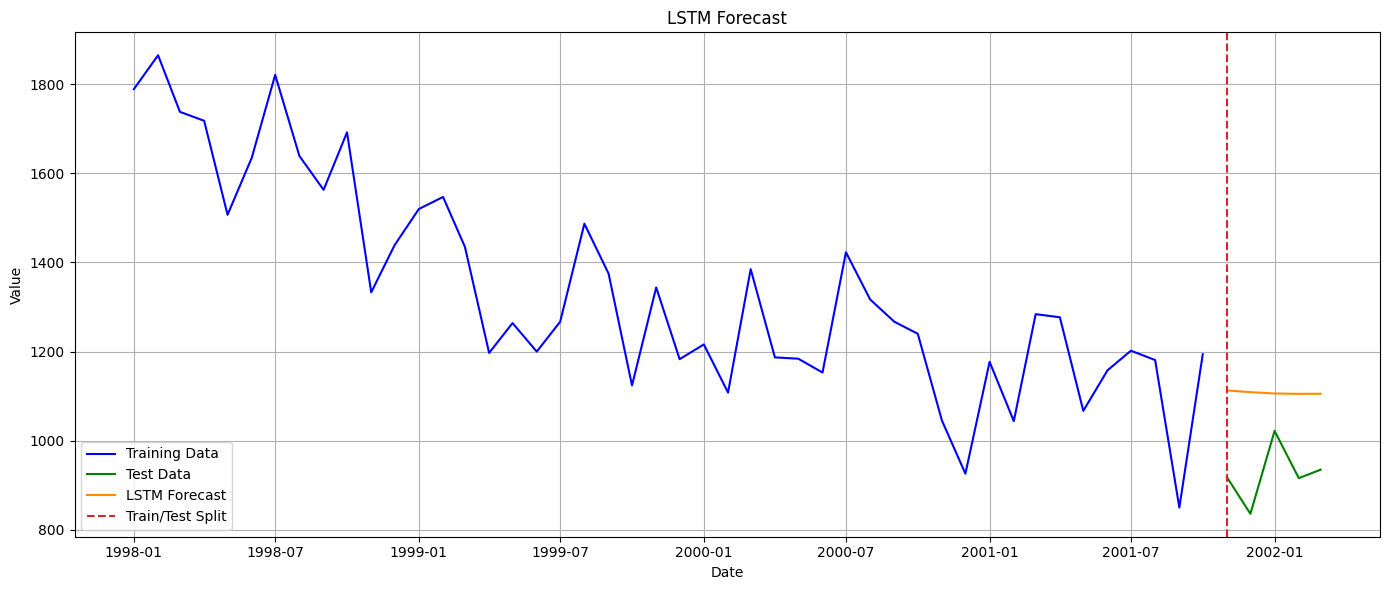

In [32]:
train_df, test_df = split_train_test(car_parts_df, test_size=0.1)
lstm_forecasts = lstm_forecast(
    train_df, test_df,
    show_plots=True
)

----------------------------------------------------------------------------------------------------------------

Auto-inferred method name: 'lstm_forecast'


/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()

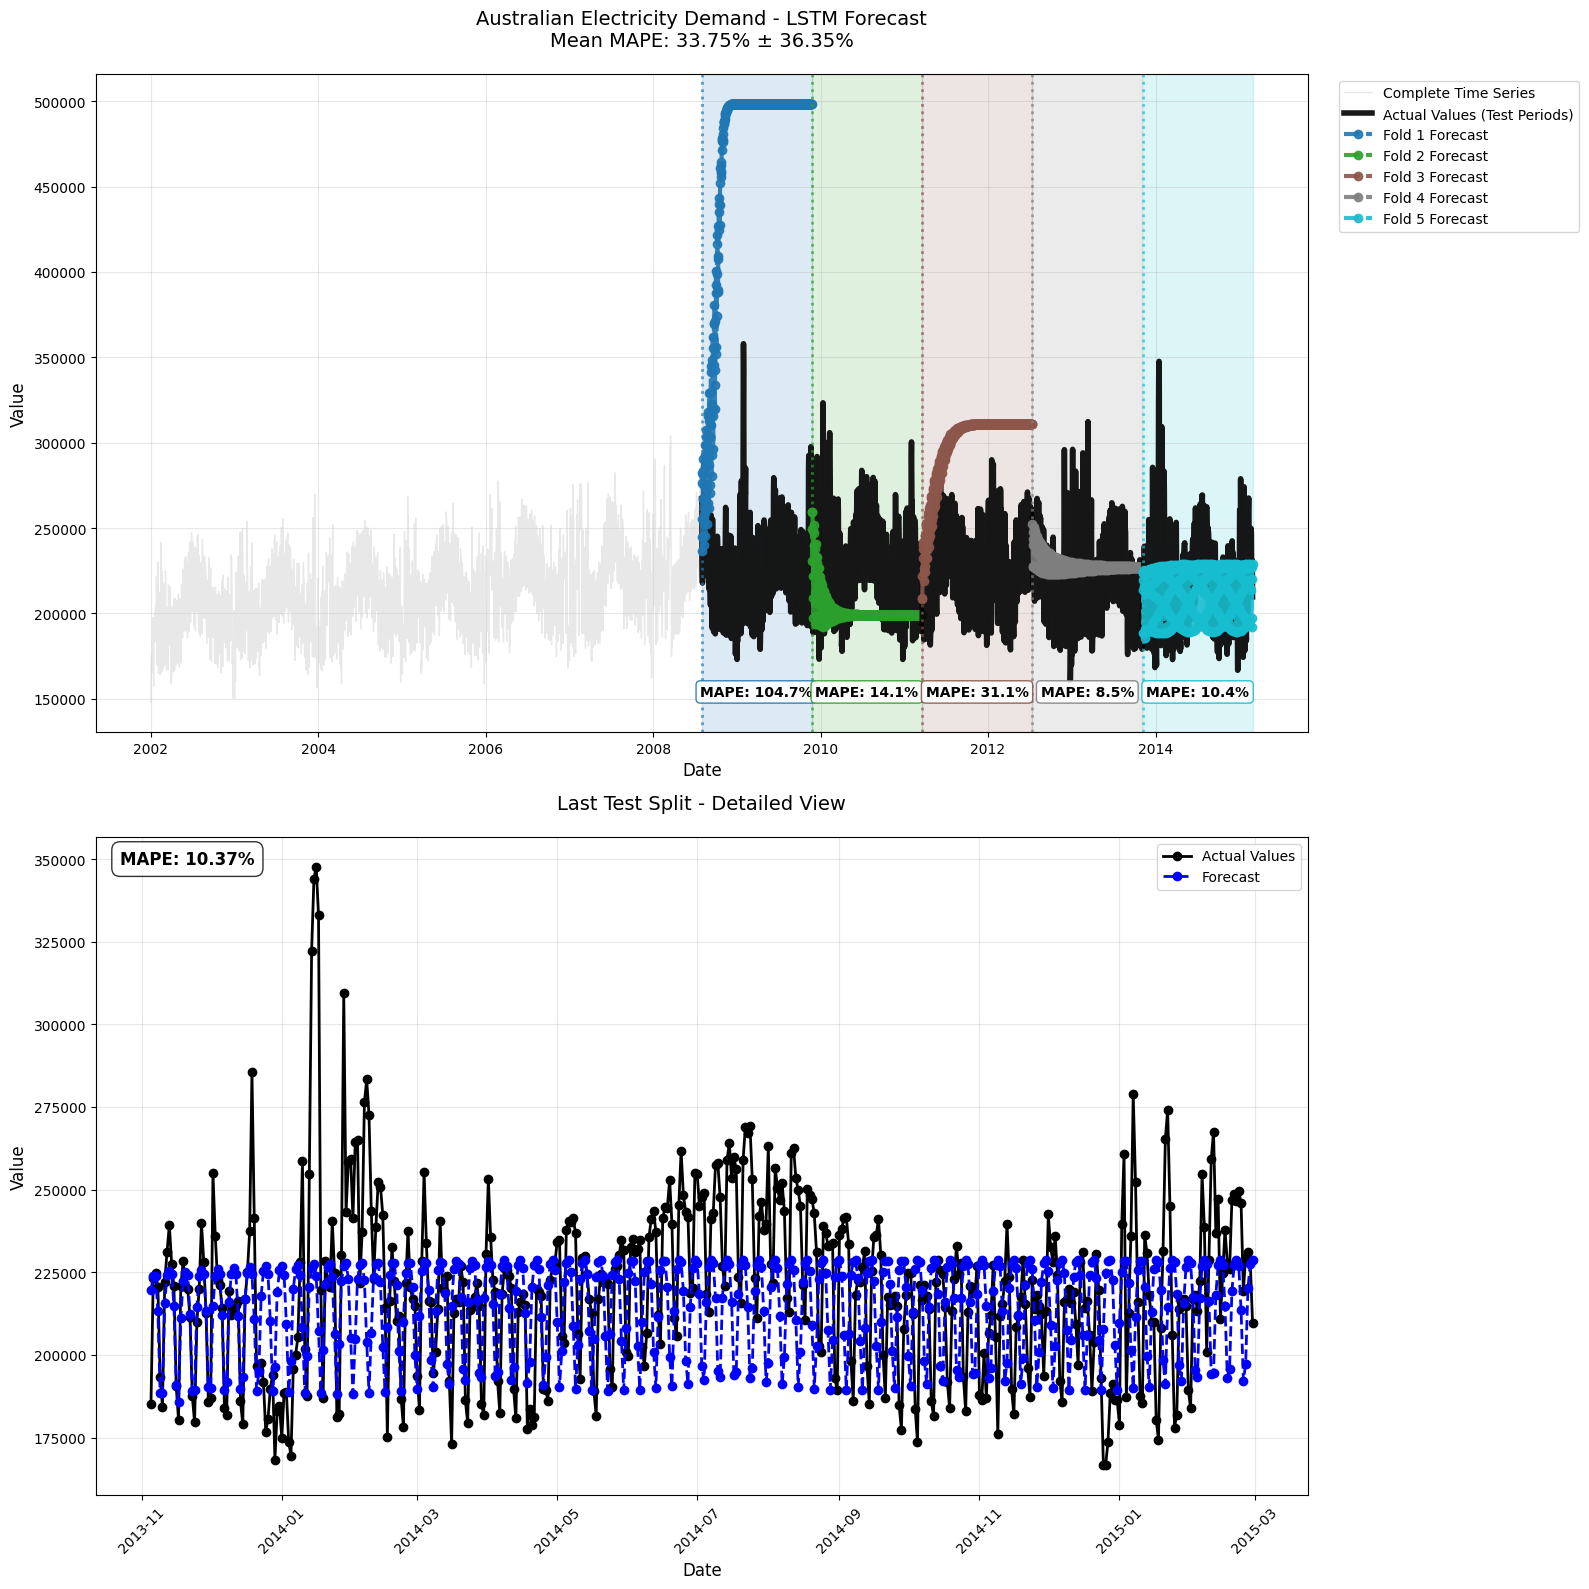


Results saved to cv_results.json under method 'lstm_forecast' for dataset 'australian_electricity_demand'
Auto-inferred method name: 'lstm_forecast'


/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()

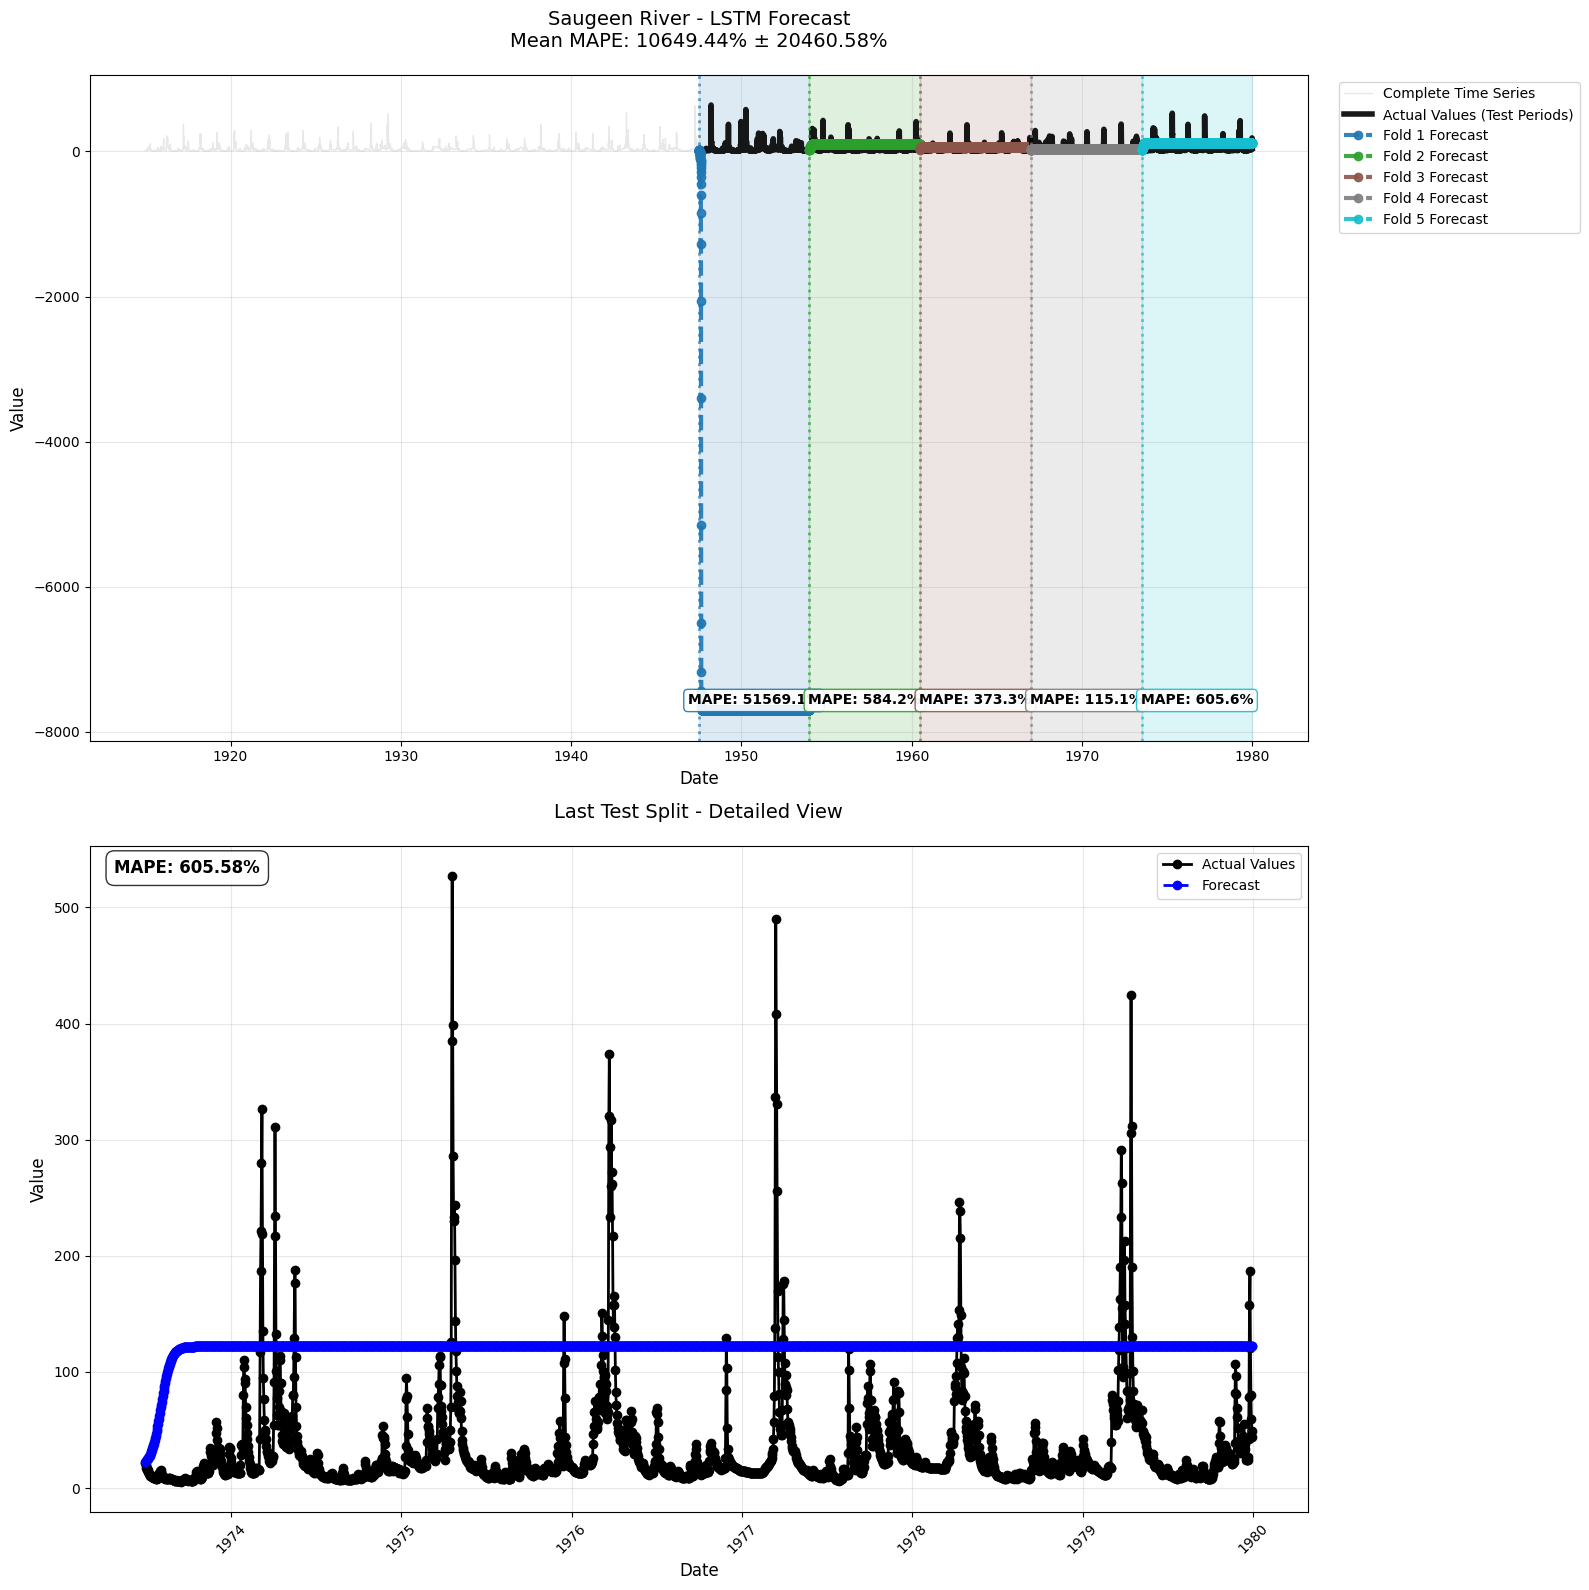


Results saved to cv_results.json under method 'lstm_forecast' for dataset 'saugeen_river'
Auto-inferred method name: 'lstm_forecast'


/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()

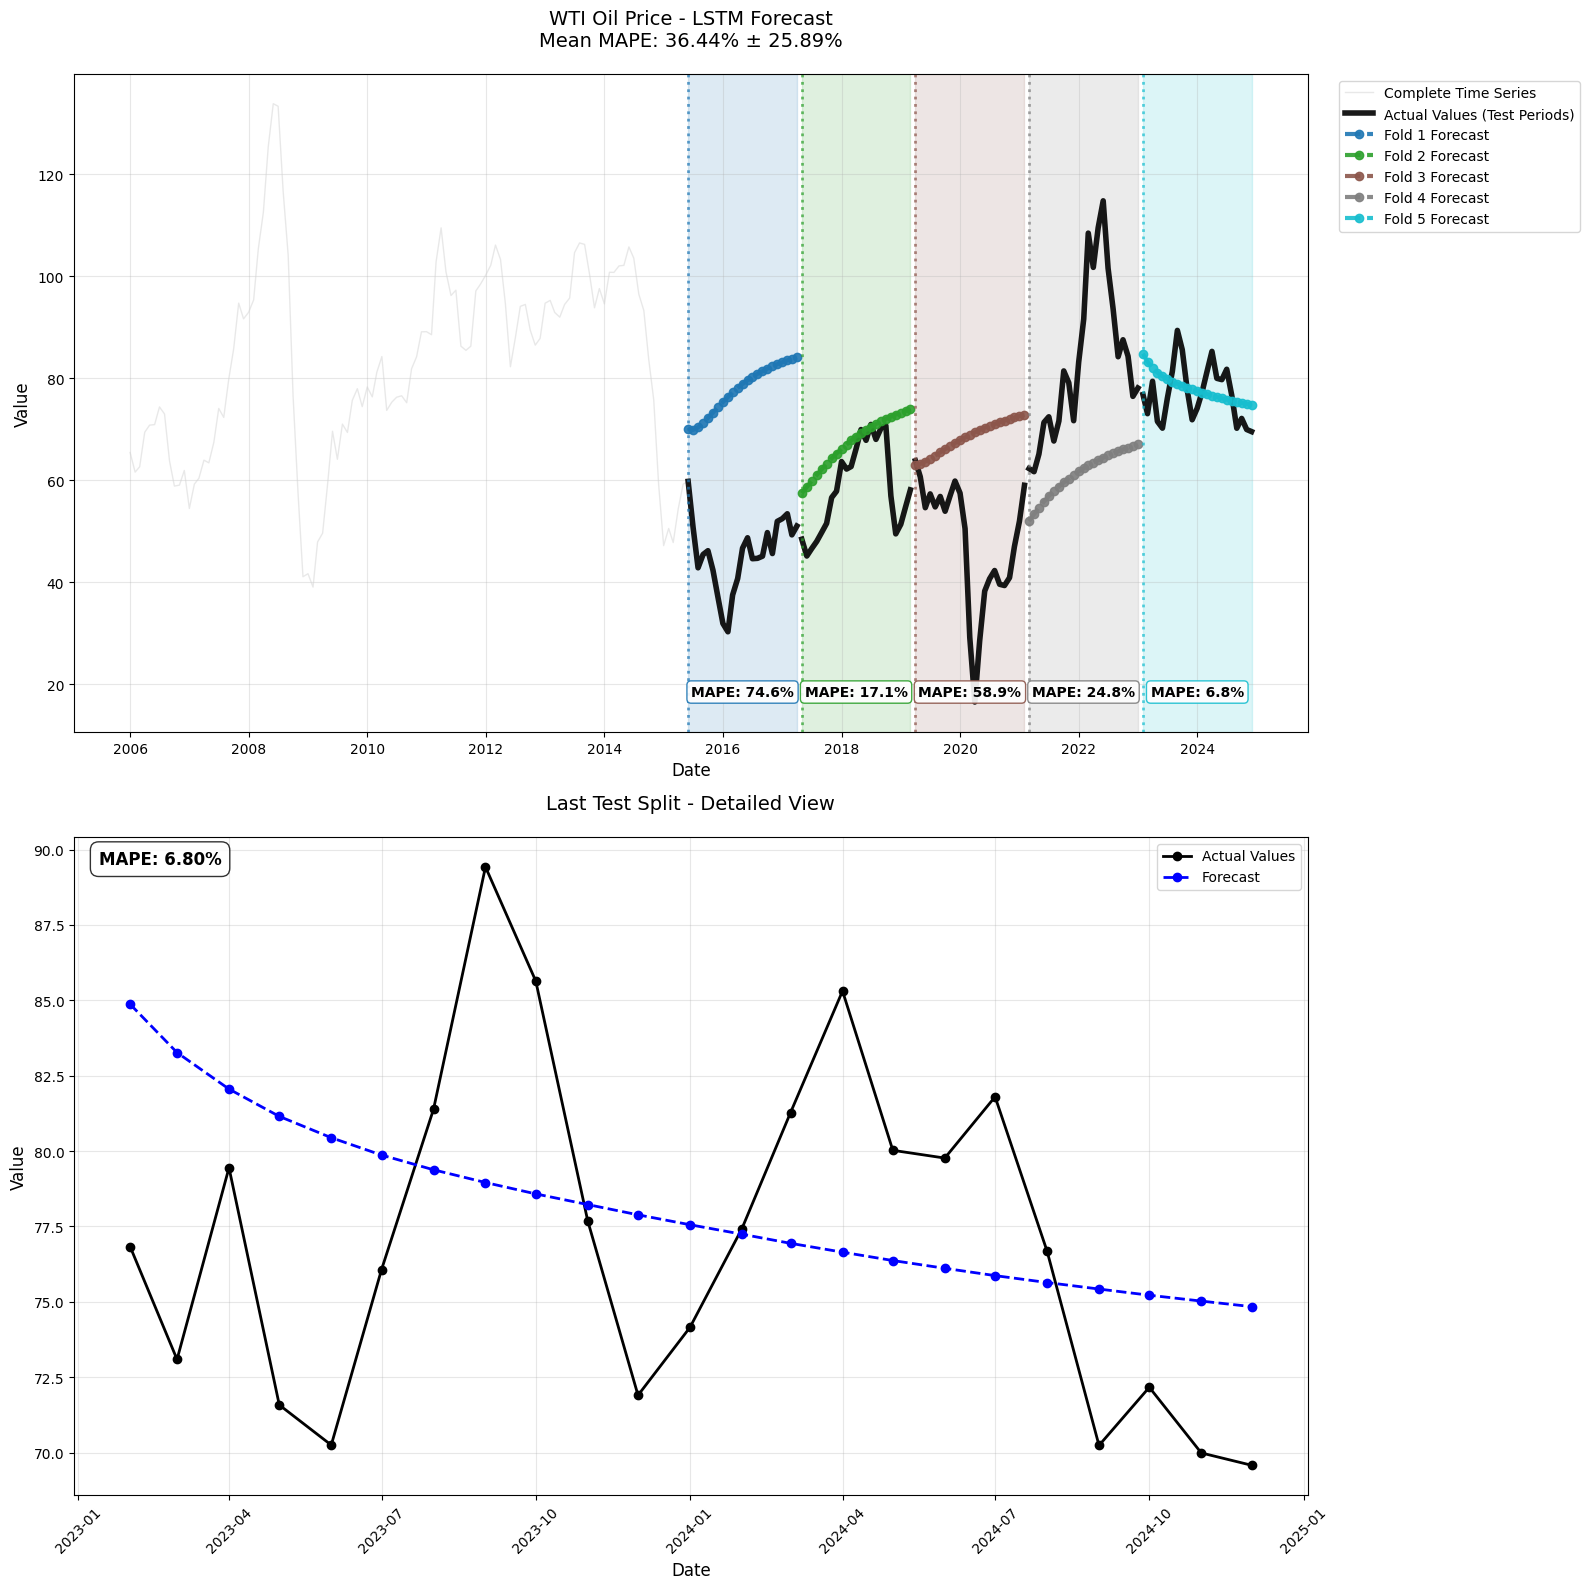


Results saved to cv_results.json under method 'lstm_forecast' for dataset 'wti_oil'
Auto-inferred method name: 'lstm_forecast'


/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()

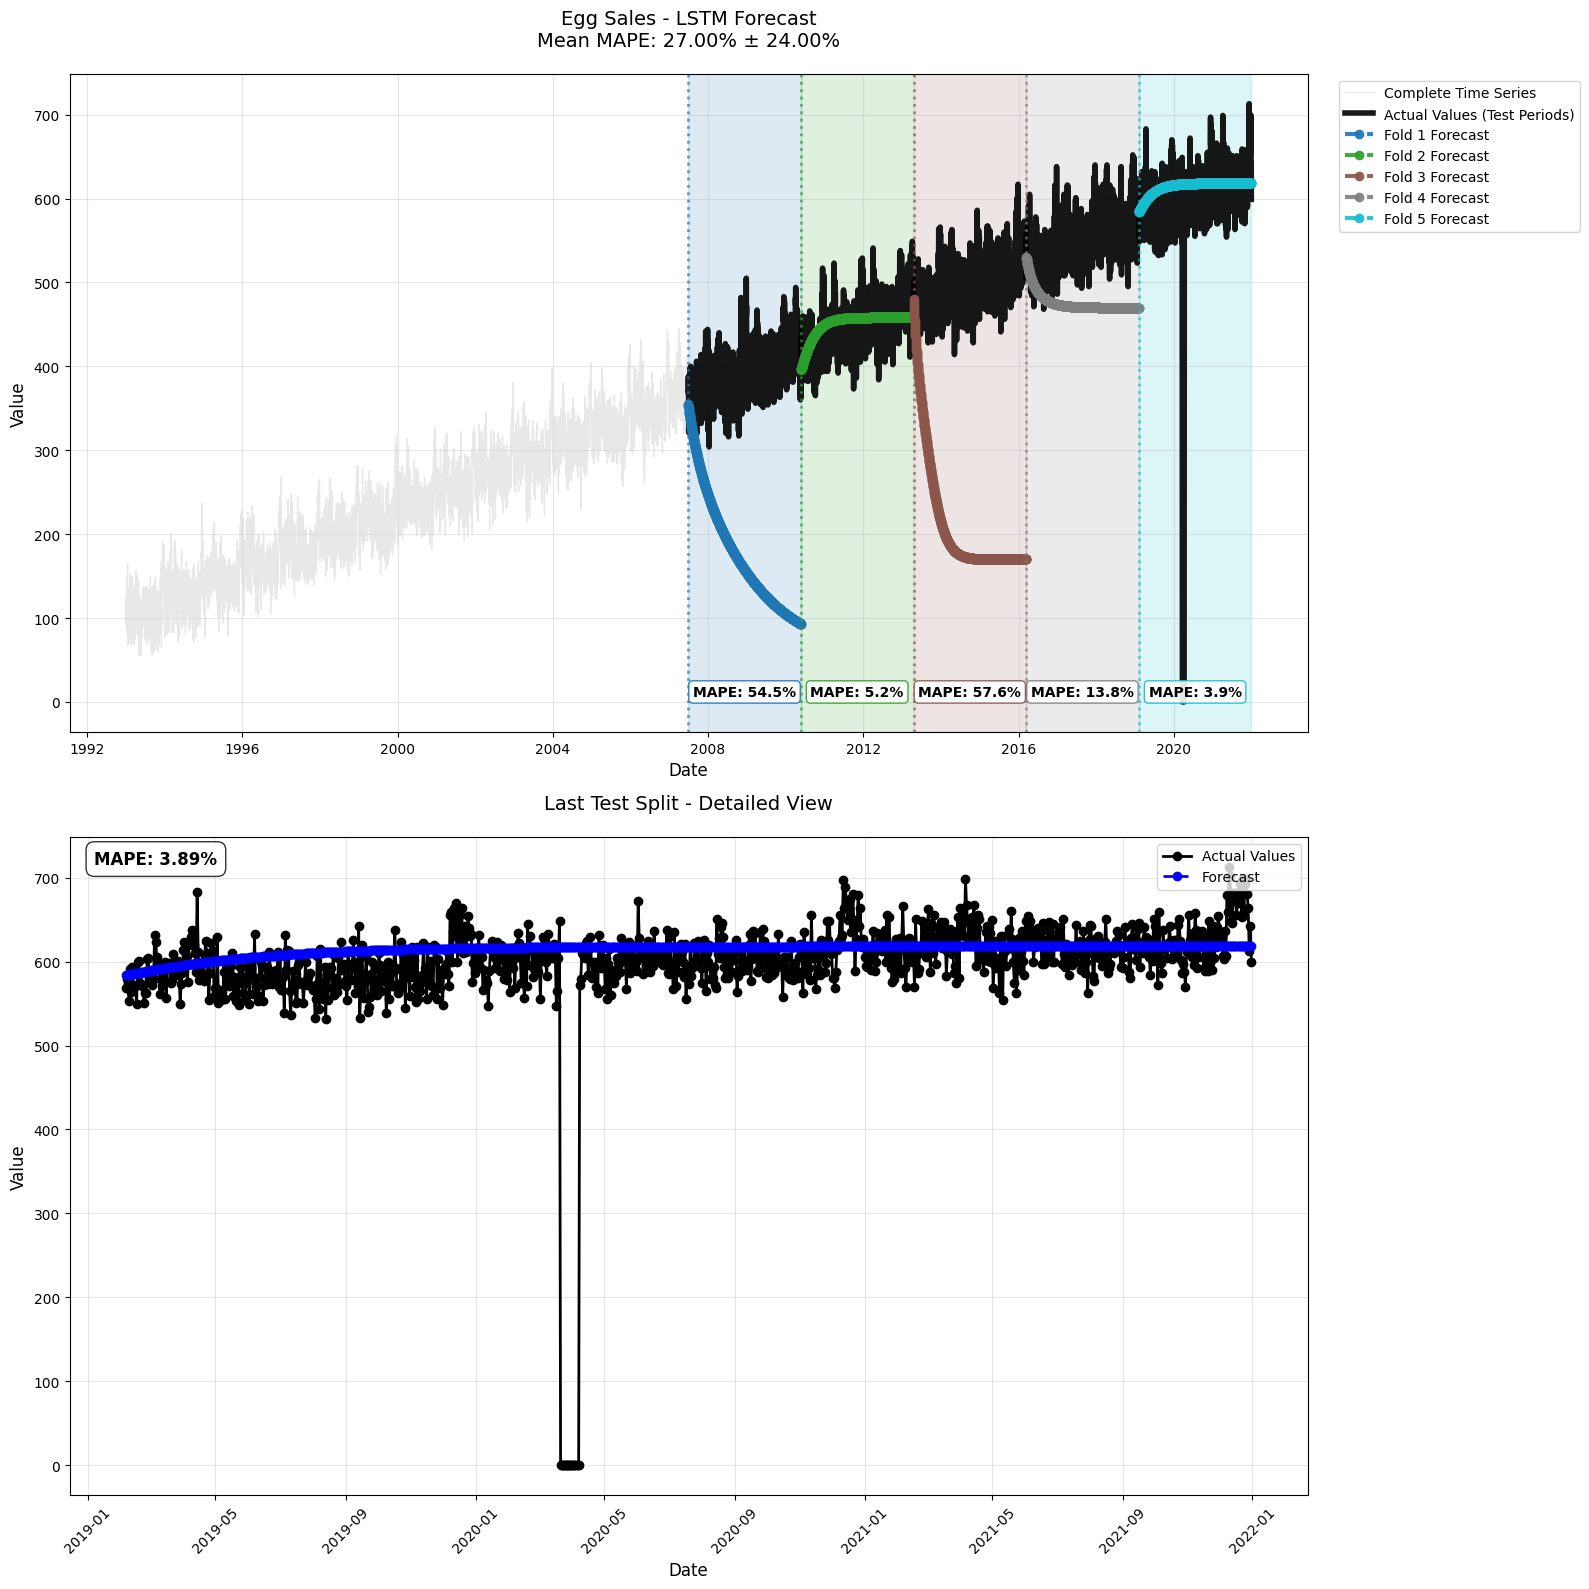


Results saved to cv_results.json under method 'lstm_forecast' for dataset 'egg_sales'
Auto-inferred method name: 'lstm_forecast'


/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kristanbottjer/Documents/Git/Time-Series-Forecasting/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()

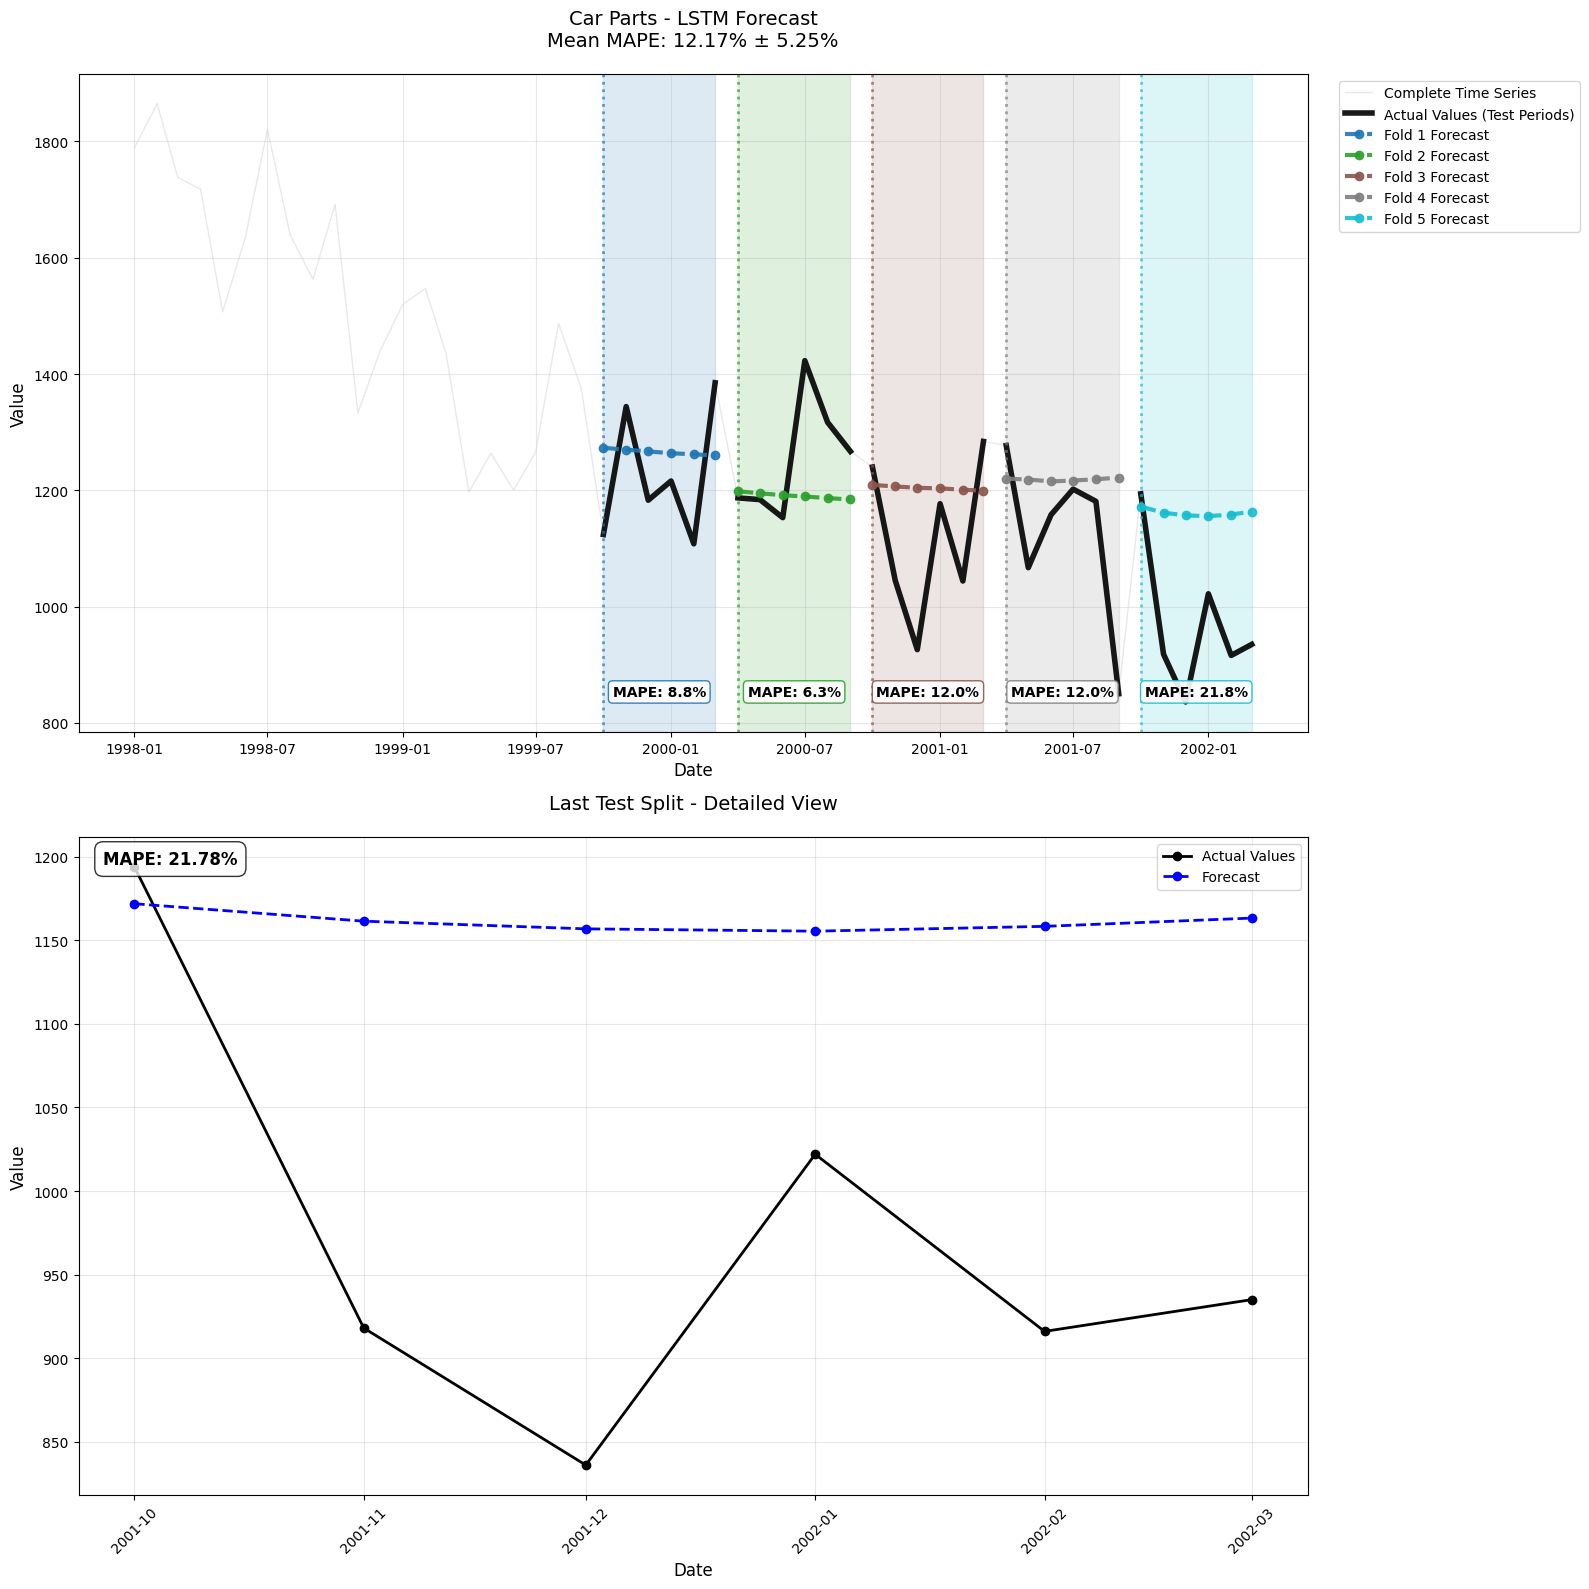


Results saved to cv_results.json under method 'lstm_forecast' for dataset 'car_parts'


In [33]:
# cv stands for cross validation in basic_functions.ipynb
plot_comprehensive_cv_results(australian_electricity_demand_df, lstm_forecast, n_splits=5, dataset_name='australian_electricity_demand',
                              title="Australian Electricity Demand - LSTM Forecast") # Australian Electricity Demand 

plot_comprehensive_cv_results(saugeen_river_df, lstm_forecast, n_splits=5, dataset_name='saugeen_river',
                              title="Saugeen River - LSTM Forecast")

plot_comprehensive_cv_results(wti_oil_df, lstm_forecast, n_splits=5, dataset_name='wti_oil',
                              title="WTI Oil Price - LSTM Forecast")

plot_comprehensive_cv_results(egg_sales_df, lstm_forecast, n_splits=5, dataset_name='egg_sales',
                              title="Egg Sales - LSTM Forecast")

plot_comprehensive_cv_results(car_parts_df, lstm_forecast, n_splits=5, dataset_name='car_parts',
                              title="Car Parts - LSTM Forecast")
